<a href="https://colab.research.google.com/github/jwyoon0917/kaggle_steel_plate_defect_prediction/blob/main/%EC%B2%A0%ED%8C%90_%EA%B2%B0%ED%95%A8_%EC%98%88%EC%B8%A1_%ED%8F%AC%ED%86%A0%ED%8F%B4%EB%A6%AC%EC%98%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Steel Plate Defect Prediction**
<img src="https://www.steelsupplylp.com/uploads/general/_1200x630_crop_center-center_82_none/plate.jpg?mtime=1672945202" alt="SteelPlate" width="600" height="315">


## **Overview**
Welcome to the 2024 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting an approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

Your Goal: Predict the probability of various defects on steel plates. Good luck!
<br>
## **Evaluation**
Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

To calculate the final score, AUC is calculated for each of the 7 defect categories and then averaged. In other words, the score is the average of the individual AUC of each predicted column.
<br>

## **Submission File**
For each id in the test set, you must predict the probability for each of 7 defect categories: Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults. The file should contain a header and have the following format:
<br>

|  id   | Pastry | Z_Scratch | K_Scatch | Stains | Dirtiness | Bumps | Other_Faults |
|------|--------|-----------|-----------|--------|-----------|-------|--------------|
| 19219| 0.5    | 0.5       | 0.5       | 0.5    | 0.5       | 0.5   | 0.5          |
| 19220| 0.5    | 0.5       | 0.5       | 0.5    | 0.5       | 0.5   | 0.5          |
| 19221| 0.5    | 0.5       | 0.5       | 0.5    | 0.5       | 0.5   | 0.5          |

<br>

## **My Grade**
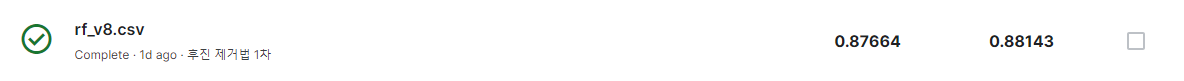

# 1. 파일 및 패키지 불러오기

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# 각각의 학습, 시험 데이터를 입력한다.
train = pd.read_csv('train.csv')
faults = pd.read_csv('faults.csv')
test = pd.read_csv('test.csv')

In [ ]:
# train과 faults를 합친 뒤, index를 새로 설정한다.
train = pd.concat([train, faults], axis=0).reset_index(drop=True)
train = train.drop('id', axis=1)

# 제출에 사용할 idx를 저장한다.
idx = test['id']

# test에서 id를 제거한다.
test = test.drop('id', axis=1)

In [ ]:
# 데이터를 제대로 가져왔는지 확인한다.
train

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21155,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
21156,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
21157,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
21158,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1


In [ ]:
# 데이터를 제대로 가져왔는지 확인한다.
test

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,1015,1033,3826564,3826588,659,23,46,62357,67,127,...,0.0095,0.5652,1.0000,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172
1,1257,1271,419960,419973,370,26,28,39293,92,132,...,0.0047,0.2414,1.0000,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104
2,1358,1372,117715,117724,289,36,32,29386,101,134,...,0.0155,0.6000,0.7500,0.0,2.4609,1.3222,1.3222,-0.5238,-0.0435,0.6514
3,158,168,232415,232440,80,10,11,8586,107,140,...,0.0037,0.8000,1.0000,1.0,1.9031,0.6990,1.0414,0.1818,-0.0738,0.2051
4,559,592,544375,544389,140,19,15,15524,103,134,...,0.0158,0.8421,0.5333,0.0,2.1461,1.3222,1.1461,-0.5714,-0.0894,0.4170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,1101,1116,447943,447992,313,32,37,21603,79,103,...,0.0126,0.4063,0.9194,1.0,2.4955,1.2305,1.6335,0.7661,-0.3109,0.8894
12810,1289,1306,3149494,3149542,59,9,18,5249,113,141,...,0.0052,0.7778,1.0000,1.0,1.7708,0.8451,1.2553,0.7222,-0.0448,0.1954
12811,41,210,1587535,1587191,16584,796,522,1858162,24,143,...,0.1236,0.2199,0.4097,0.0,4.2525,2.2504,2.2672,-0.0629,-0.0801,1.0000
12812,1329,1340,702237,702267,386,43,34,36875,66,124,...,0.0095,0.2407,1.0000,1.0,2.5866,1.1139,1.5911,0.8461,-0.2629,0.7844


# 2. 베이스라인 생성 : 0.87111

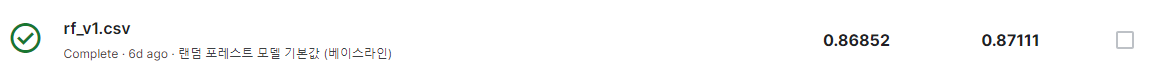

## 2-1. 타겟(예측 대상) 분리

In [ ]:
# 7개의 결함에 속할 확률을 계산하는 MultiLabel 문제
targets = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

In [ ]:
# train, test 데이터로부터 targets를 분리한다.
X_train = train.drop(targets, axis=1)
y_train = train[targets]
X_test = test

In [ ]:
# 분리가 제대로 되었는지 확인한다.
X_train

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,584,590,909972,909977,16,8,5,2274,113,140,...,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21155,249,277,325780,325796,273,54,22,35033,119,141,...,0.0206,0.5185,0.7273,0.0,2.4362,1.4472,1.2041,-0.4286,0.0026,0.7254
21156,144,175,340581,340598,287,44,24,34599,112,133,...,0.0228,0.7046,0.7083,0.0,2.4579,1.4914,1.2305,-0.4516,-0.0582,0.8173
21157,145,174,386779,386794,292,40,22,37572,120,140,...,0.0213,0.7250,0.6818,0.0,2.4654,1.4624,1.1761,-0.4828,0.0052,0.7079
21158,137,170,422497,422528,419,97,47,52715,117,140,...,0.0243,0.3402,0.6596,0.0,2.6222,1.5185,1.4914,-0.0606,-0.0171,0.9919


In [ ]:
y_train

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
21155,0,0,0,0,0,0,1
21156,0,0,0,0,0,0,1
21157,0,0,0,0,0,0,1
21158,0,0,0,0,0,0,1


## 2-2. 랜덤 포레스트 모델 예측(기본값)

In [ ]:
# 랜덤 포레스트 기본값을 생성한다. (random_state = 42 고정)
rf = RandomForestClassifier(random_state=42)

# 랜덤 포레스트 모델을 학습한다.
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# 각각의 결과에 속할 확률을 계산하여 저장한다.
rf_probs = rf.predict_proba(X_test)

# 해당 배열을 numpy 배열로 변환한다.
rf_probs_np = np.array(rf_probs)

rf_probs_np

array([[[0.65, 0.35],
        [0.73, 0.27],
        [1.  , 0.  ],
        ...,
        [1.  , 0.  ],
        [0.63, 0.37],
        [1.  , 0.  ]],

       [[0.98, 0.02],
        [0.99, 0.01],
        [0.85, 0.15],
        ...,
        [1.  , 0.  ],
        [0.98, 0.02],
        [1.  , 0.  ]],

       [[1.  , 0.  ],
        [1.  , 0.  ],
        [0.96, 0.04],
        ...,
        [0.1 , 0.9 ],
        [0.95, 0.05],
        [0.1 , 0.9 ]],

       ...,

       [[0.96, 0.04],
        [0.82, 0.18],
        [1.  , 0.  ],
        ...,
        [1.  , 0.  ],
        [0.89, 0.11],
        [1.  , 0.  ]],

       [[0.87, 0.13],
        [0.84, 0.16],
        [0.74, 0.26],
        ...,
        [1.  , 0.  ],
        [0.93, 0.07],
        [1.  , 0.  ]],

       [[0.57, 0.43],
        [0.69, 0.31],
        [0.52, 0.48],
        ...,
        [0.91, 0.09],
        [0.73, 0.27],
        [0.92, 0.08]]])

In [ ]:
# 0(클래스에 속하지 않을 확률), 1(클래스에 속할 확률)을 얻을 수 있다.
# 그중 클래스에 속할 확률만을 따로 분리한다.
class_probs = rf_probs_np[:,:,1]

# 클래스에 속할 확률을 데이터프레임으로 저장한다.
# 해당 데이터프레임의 열을 targets로 설정한다.
result_v1 = pd.DataFrame(class_probs).T
result_v1.columns = targets

# 결과를 확인한다.
result_v1

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.35,0.02,0.00,0.00,0.04,0.13,0.43
1,0.27,0.01,0.00,0.00,0.18,0.16,0.31
2,0.00,0.15,0.04,0.02,0.00,0.26,0.48
3,0.10,0.00,0.00,0.00,0.00,0.49,0.40
4,0.02,0.04,0.00,0.00,0.00,0.57,0.33
...,...,...,...,...,...,...,...
12809,0.15,0.07,0.01,0.00,0.07,0.25,0.38
12810,0.06,0.01,0.04,0.02,0.18,0.26,0.39
12811,0.00,0.00,0.90,0.00,0.00,0.00,0.09
12812,0.37,0.02,0.05,0.00,0.11,0.07,0.27


In [ ]:
# result_v1 데이터프레임에 id 열을 추가한다.
result_v1.insert(0, 'id', idx)

# 해당 데이터프레임을 csv 파일(제출용)로 저장한다.
result_v1.to_csv('rf_v1.csv', index=False)

# 3. 데이터 분석 및 전처리

## 3-1. 데이터 분석

In [ ]:
# 모든 열에 대해서 Null 값이 없는 것을 확인할 수 있다.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21160 entries, 0 to 21159
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              21160 non-null  int64  
 1   X_Maximum              21160 non-null  int64  
 2   Y_Minimum              21160 non-null  int64  
 3   Y_Maximum              21160 non-null  int64  
 4   Pixels_Areas           21160 non-null  int64  
 5   X_Perimeter            21160 non-null  int64  
 6   Y_Perimeter            21160 non-null  int64  
 7   Sum_of_Luminosity      21160 non-null  int64  
 8   Minimum_of_Luminosity  21160 non-null  int64  
 9   Maximum_of_Luminosity  21160 non-null  int64  
 10  Length_of_Conveyer     21160 non-null  int64  
 11  TypeOfSteel_A300       21160 non-null  int64  
 12  TypeOfSteel_A400       21160 non-null  int64  
 13  Steel_Plate_Thickness  21160 non-null  int64  
 14  Edges_Index            21160 non-null  float64
 15  Em

In [ ]:
# train의 상위 5번째 값을 알아본다.
train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [ ]:
# train의 하위 5번째 값을 알아본다.
train.tail()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
21155,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
21156,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
21157,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
21158,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1
21159,1261,1281,87951,87967,103,26,22,11682,101,133,...,-0.2000,-0.1139,0.5296,0,0,0,0,0,0,1


In [ ]:
# train의 모든 열은 int, float이므로 describe 결과가 모두 도출된다.
# describe의 결과, 값들 간의 편차가 매우 큰 것을 확인할 수 있다.
# 랜덤 포레스트는 표준화를 하지 않아도 성능에 큰 차이가 없지만, 표준화를 진행한다.
train.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,21160.000000,21160.000000,2.116000e+04,2.116000e+04,21160.000000,21160.000000,21160.000000,2.116000e+04,21160.000000,21160.000000,...,21160.000000,21160.000000,21160.000000,21160.000000,21160.000000,21160.000000,21160.000000,21160.000000,21160.000000,21160.000000
mean,697.130057,741.392202,1.831495e+06,1.828639e+06,1703.240832,97.140737,65.852457,1.931736e+05,84.784594,128.789225,...,0.100958,-0.137733,0.573142,0.076749,0.063327,0.180671,0.030246,0.025520,0.244093,0.341730
std,532.054574,501.160090,1.892922e+06,1.886266e+06,3884.800851,192.510008,161.187566,4.489348e+05,29.121342,14.672936,...,0.488925,0.123237,0.332903,0.266198,0.243556,0.384755,0.171267,0.157701,0.429558,0.474301
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,214.000000,6.394900e+05,6.395070e+05,88.000000,15.000000,14.000000,9.778000e+03,68.000000,124.000000,...,-0.272700,-0.192600,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,754.000000,772.000000,1.378585e+06,1.378261e+06,169.000000,25.000000,24.000000,1.840200e+04,90.000000,127.000000,...,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1145.000000,1161.000000,2.339627e+06,2.336466e+06,659.000000,67.000000,62.000000,6.841600e+04,105.000000,135.000000,...,0.526300,-0.082800,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3-1-1. 표준화 : 0.87121

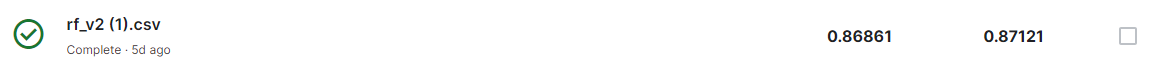

In [ ]:
# 표준화 객체를 생성한다.
std_scaler = StandardScaler()

# X_train을 std_scaler에 fit 한 뒤 transform한다.
X_train_std = std_scaler.fit_transform(X_train)

# X_test는 학습된 std_scaler를 바탕으로 transform을 진행한다.
X_test_std = std_scaler.transform(X_test)

In [ ]:
# 변환된 X_train_std, X_test_std를 데이터프레임으로 복원한다.
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_test.columns)

In [ ]:
# rf_v2 랜덤 포레스트 객체를 생성한다.
rf_v2 = RandomForestClassifier(random_state=42)

rf_v2.fit(X_train_std, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# 각각의 결과에 속할 확률을 계산한다.
rf_probs = rf_v2.predict_proba(X_test_std)

# 확률값을 numpy 배열로 변환한다.
rf_probs_np = np.array(rf_probs)

# 각 클래스에 속할 확률만을 추출한다.
class_probs = rf_probs_np[:,:,1]

# 확률을 데이터프레임으로 변환한다.
result_v2 = pd.DataFrame(class_probs).T
result_v2.columns = targets

# 결과 확인
result_v2

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.35,0.02,0.00,0.00,0.04,0.13,0.43
1,0.27,0.01,0.00,0.00,0.18,0.16,0.31
2,0.00,0.15,0.04,0.02,0.00,0.24,0.50
3,0.10,0.00,0.00,0.00,0.00,0.49,0.40
4,0.02,0.04,0.00,0.00,0.00,0.57,0.33
...,...,...,...,...,...,...,...
12809,0.15,0.07,0.01,0.00,0.07,0.25,0.38
12810,0.06,0.01,0.04,0.02,0.18,0.26,0.39
12811,0.00,0.00,0.90,0.00,0.00,0.00,0.09
12812,0.37,0.02,0.05,0.00,0.11,0.07,0.27


In [ ]:
# 결과를 csv 파일로 저장한다.
result_v2.insert(0, 'id', idx)
result_v2.to_csv('rf_v2.csv', index=False)

### 3-1-2. PCA : 0.63264

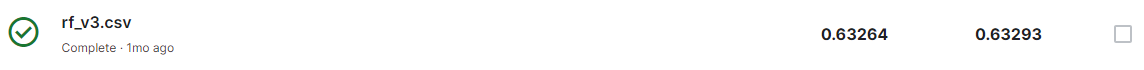

In [ ]:
# 변수가 많은 고차원의 데이터이므로, 차원의 저주를 해소하기 위한 PCA를 진행해본다

In [ ]:
from sklearn.decomposition import PCA

# 주성분을 선택했을 때 전체 분산의 95%를 설명할 수 있도록 설정한다
# train, test 데이터를 PCA 진행한다.
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# PCA한 결과를 데이터프레임으로 변환한다
X_train_pca = pd.DataFrame(X_train_pca, columns=['PC' + str(i+1) for i in range(X_train_pca.shape[1])])
X_test_pca = pd.DataFrame(X_test_pca, columns=['PC' + str(i+1) for i in range(X_test_pca.shape[1])])

In [ ]:
# 랜덤 포레스트 기본값으로 성능을 측정한다
rf_v3 = RandomForestClassifier(n_estimators=100, random_state=42)

rf_v3.fit(X_train_pca, y_train)

In [ ]:
# 분류 가능성을 계산한다
rf_probs = rf_v3.predict_proba(X_test_pca)

In [ ]:
# numpy 배열로 변환
rf_probs_np = np.array(rf_probs)

# 각 클래스에 속할 확률만을 추출
class_probs = rf_probs_np[:,:,1]

# DataFrame 생성
result_v3 = pd.DataFrame(class_probs).T
result_v3.columns = targets

# 결과 확인
result_v3

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.50,0.00,0.030,0.0,0.00,0.010,0.46
1,0.01,0.00,0.040,0.0,0.00,0.270,0.68
2,0.00,0.01,0.230,0.0,0.00,0.650,0.11
3,0.00,0.00,0.220,0.0,0.00,0.580,0.20
4,0.00,0.00,0.000,0.0,0.65,0.020,0.33
...,...,...,...,...,...,...,...
12809,0.00,0.00,0.710,0.0,0.00,0.290,0.00
12810,0.00,0.00,0.025,0.0,0.00,0.345,0.03
12811,0.00,0.00,1.000,0.0,0.00,0.000,0.00
12812,0.02,0.00,0.000,0.0,0.00,0.070,0.91


In [ ]:
# 결과를 csv 파일로 저장한다.
result_v3.insert(0, 'id', idx)
result_v3.to_csv('rf_v3.csv', index=False)

## 3-2. 데이터 전처리

### 3-2-1. 피쳐 엔지니어링 : 0.87202

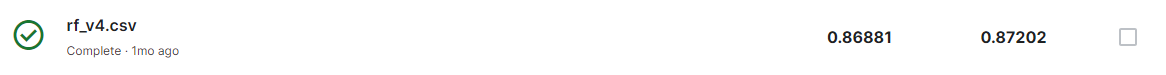

In [ ]:
# 각 특성의 중요도 출력
feature_importances = rf_v2.feature_importances_
num_features = len(feature_importances)

# 각 특성과 그에 대응하는 중요도를 출력
for i in range(num_features):
    print(f"Feature {i + 1}: {X_train_std.columns[i]} - Importance: {feature_importances[i]}")

Feature 1: X_Minimum - Importance: 0.040604452891328656
Feature 2: X_Maximum - Importance: 0.040360499088609336
Feature 3: Y_Minimum - Importance: 0.03408065229429347
Feature 4: Y_Maximum - Importance: 0.0335842417872367
Feature 5: Pixels_Areas - Importance: 0.05452203752921991
Feature 6: X_Perimeter - Importance: 0.04460686854921292
Feature 7: Y_Perimeter - Importance: 0.035806734225847334
Feature 8: Sum_of_Luminosity - Importance: 0.04541146375520901
Feature 9: Minimum_of_Luminosity - Importance: 0.03835257930009892
Feature 10: Maximum_of_Luminosity - Importance: 0.02774063003040126
Feature 11: Length_of_Conveyer - Importance: 0.04409688480150522
Feature 12: TypeOfSteel_A300 - Importance: 0.009131745176229517
Feature 13: TypeOfSteel_A400 - Importance: 0.008190749606655057
Feature 14: Steel_Plate_Thickness - Importance: 0.038100165309142925
Feature 15: Edges_Index - Importance: 0.03819344545750126
Feature 16: Empty_Index - Importance: 0.03858614326443235
Feature 17: Square_Index - Imp

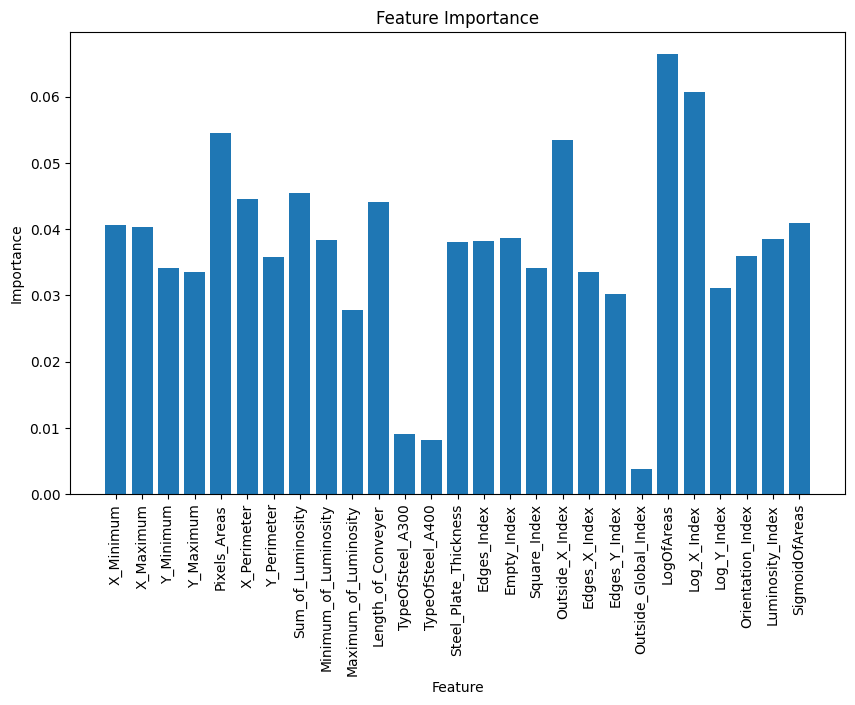

In [ ]:
import matplotlib.pyplot as plt

# 각 특성별 중요도를 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(num_features), feature_importances, align='center')
plt.xticks(range(num_features), X_train_std.columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [ ]:
# 새로운 특징 범위를 만든다
# 로그 스케일을 해제한다
train['X_range'] = train['X_Maximum'] - train['X_Minimum']
train['Y_range'] = train['Y_Maximum'] - train['Y_Minimum']
train['Luminosity_range'] = train['Maximum_of_Luminosity'] - train['Minimum_of_Luminosity']
train['Area'] = np.exp(train['LogOfAreas'])
train['X_Index'] = np.exp(train['Log_X_Index'])
train['Y_Index'] = np.exp(train['Log_Y_Index'])

test['X_range'] = test['X_Maximum'] - test['X_Minimum']
test['Y_range'] = test['Y_Maximum'] - test['Y_Minimum']
test['Luminosity_range'] = test['Maximum_of_Luminosity'] - test['Minimum_of_Luminosity']
test['Area'] = np.exp(test['LogOfAreas'])
test['X_Index'] = np.exp(test['Log_X_Index'])
test['Y_Index'] = np.exp(test['Log_Y_Index'])

In [ ]:
# 학습 데이터, 시험 데이터를 설정한다
X_train = train.drop(targets, axis=1)
y_train = train[targets]
X_test = test

In [ ]:
rf_v4 = RandomForestClassifier(n_estimators=100, random_state=42)

rf_v4.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
rf_probs = rf_v4.predict_proba(X_test)

In [ ]:
# numpy 배열로 변환
rf_probs_np = np.array(rf_probs)

# 각 클래스에 속할 확률만을 추출
class_probs = rf_probs_np[:,:,1]

# DataFrame 생성
result_v4 = pd.DataFrame(class_probs).T
result_v4.columns = targets

# 결과 확인
result_v4

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.36,0.02,0.01,0.00,0.11,0.17,0.31
1,0.26,0.04,0.01,0.00,0.10,0.21,0.35
2,0.01,0.07,0.03,0.01,0.01,0.28,0.53
3,0.14,0.03,0.00,0.00,0.01,0.38,0.43
4,0.01,0.06,0.00,0.01,0.03,0.41,0.42
...,...,...,...,...,...,...,...
12809,0.16,0.08,0.01,0.00,0.03,0.23,0.45
12810,0.16,0.02,0.02,0.05,0.25,0.16,0.29
12811,0.00,0.00,0.84,0.00,0.00,0.00,0.14
12812,0.37,0.02,0.02,0.00,0.04,0.14,0.32


In [ ]:
# 결과를 csv 파일로 저장한다.
result_v4.insert(0, 'id', idx)
result_v4.to_csv('rf_v4.csv', index=False)

### 3-2-2. 스케일링 추가 : 0.87206

In [ ]:
# 위에서 스케일링한 결과가 정확도가 조금 더 높았으므로
# 새로운 특징에도 스케일링을 적용해본다

In [ ]:
# 데이터프레임에 스케일링을 적용한다
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_test.columns)

In [ ]:
rf_v5 = RandomForestClassifier(n_estimators=100, random_state=42)

rf_v5.fit(X_train_std, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
rf_probs = rf_v5.predict_proba(X_test_std)

In [ ]:
# numpy 배열로 변환
rf_probs_np = np.array(rf_probs)

# 각 클래스에 속할 확률만을 추출
class_probs = rf_probs_np[:,:,1]

# DataFrame 생성
result_v5 = pd.DataFrame(class_probs).T
result_v5.columns = targets

# 결과 확인
result_v5

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.36,0.02,0.01,0.00,0.11,0.17,0.31
1,0.26,0.04,0.01,0.00,0.10,0.20,0.36
2,0.01,0.07,0.03,0.01,0.01,0.28,0.53
3,0.14,0.03,0.00,0.00,0.01,0.37,0.43
4,0.01,0.06,0.00,0.01,0.03,0.41,0.42
...,...,...,...,...,...,...,...
12809,0.16,0.08,0.01,0.00,0.03,0.23,0.45
12810,0.15,0.02,0.02,0.05,0.25,0.17,0.29
12811,0.00,0.00,0.84,0.00,0.00,0.00,0.14
12812,0.37,0.02,0.02,0.00,0.04,0.14,0.32


In [ ]:
# 결과를 csv 파일로 저장한다
result_v5.insert(0, 'id', idx)
result_v5.to_csv('rf_v5.csv', index=False)

### 3-2-3. 범주형 변수 제외 : 0.87121

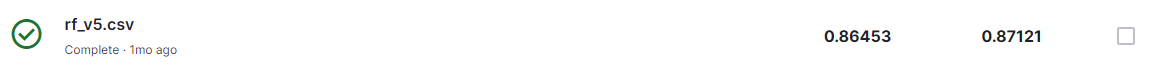

In [ ]:
# 이전 결과는 TypeOfSteel과 같은 범주형 변수도 표준화를 진행했다
# 범주형 변수를 제외하고 표준화를 진행하도록 변경한다

In [ ]:
# 인덱스 제거 작업
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [ ]:
# 범주형 변수를 따로 저장한다
X_train_A300 = X_train.TypeOfSteel_A300
X_train_A400 = X_train.TypeOfSteel_A400
X_test_A300 = X_test.TypeOfSteel_A300
X_test_A400 = X_test.TypeOfSteel_A400

X_train = X_train.drop(['TypeOfSteel_A300', 'TypeOfSteel_A400'], axis=1)
X_test = X_test.drop(['TypeOfSteel_A300', 'TypeOfSteel_A400'], axis=1)

In [ ]:
# 표준화 스케일링을 진행한다
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

In [ ]:
# 학습 데이터, 시험 데이터를 데이터프레임으로 만든다
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_test.columns)

In [ ]:
# 범주형 변수를 추가해준다
X_train_std = pd.concat([X_train_std, X_train_A300, X_train_A400], axis=1)
X_test_std = pd.concat([X_test_std, X_test_A300, X_test_A400], axis=1)

In [ ]:
# 랜덤 포레스트로 학습한다
rf_v6 = RandomForestClassifier(n_estimators=100, random_state=42)

rf_v6.fit(X_train_std, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# 분류 가능성을 추출한다
rf_probs = rf_v6.predict_proba(X_test_std)

In [ ]:
# numpy 배열로 변환
rf_probs_np = np.array(rf_probs)

# 각 클래스에 속할 확률만을 추출
class_probs = rf_probs_np[:,:,1]

# DataFrame 생성
result_v6 = pd.DataFrame(class_probs).T
result_v6.columns = targets

# 결과 확인
result_v6

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.34,0.00,0.00,0.01,0.06,0.20,0.34
1,0.21,0.06,0.01,0.00,0.17,0.15,0.36
2,0.00,0.06,0.05,0.02,0.02,0.35,0.45
3,0.16,0.03,0.00,0.00,0.03,0.41,0.37
4,0.01,0.03,0.00,0.00,0.00,0.53,0.39
...,...,...,...,...,...,...,...
12809,0.17,0.12,0.01,0.01,0.07,0.23,0.32
12810,0.23,0.01,0.01,0.04,0.17,0.15,0.31
12811,0.00,0.00,0.89,0.00,0.00,0.00,0.07
12812,0.33,0.02,0.01,0.00,0.06,0.18,0.33


In [ ]:
# 결과를 csv 파일로 저장한다
result_v6.insert(0, 'id', idx)
result_v6.to_csv('rf_v6.csv', index=False)

# 4. 최적화 : 0.87618

## 4-1. 하이퍼파라미터 최적화

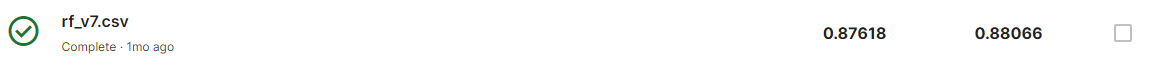

In [ ]:
# 가장 성능이 높았던 6번을 기준으로 최적화를 진행한다

In [ ]:
# 베이스라인 랜덤 포레스트를 설정한다
rf_v7 = RandomForestClassifier(random_state=42)

In [ ]:
# 그리드 서치를 기반으로 하이퍼파라미터 최적화를 진행한다

# from sklearn.model_selection import GridSearchCV

# # 탐색할 하이퍼파라미터 그리드 정의
# param_grid = {
#     'n_estimators': [300, 500, 700],
#     'max_depth': [None, 10, 20],
#     'bootstrap': [True, False],
#     'verbose': [1]
# }

# # GridSearchCV 객체 생성
# grid_search = GridSearchCV(rf_v7, param_grid, cv=10, scoring='roc_auc')

# # GridSearchCV 수행
# grid_search.fit(X_train_std, y_train)

# # 최적의 하이퍼파라미터 출력
# print("Best Parameters:", grid_search.best_params_)

# best_params = grid_search.best_params_

In [ ]:
best_params = {'bootstrap': True, 'max_depth': 20, 'n_estimators': 700, 'verbose': 1}

In [ ]:
rf_v7 = RandomForestClassifier(**best_params)

In [ ]:
rf_v7.fit(X_train_std, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   30.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  1.1min


RandomForestClassifier(max_depth=20, n_estimators=700, verbose=1)

In [ ]:
rf_probs = rf_v7.predict_proba(X_test_std)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    4.5s


In [ ]:
# numpy 배열로 변환
rf_probs_np = np.array(rf_probs)

# 각 클래스에 속할 확률만을 추출
class_probs = rf_probs_np[:,:,1]

# DataFrame 생성
result_v7 = pd.DataFrame(class_probs).T
result_v7.columns = targets

# 결과 확인
result_v7

In [ ]:
# 결과를 csv 파일로 저장한다
result_v7.insert(0, 'id', idx)
result_v7.to_csv('rf_v7.csv', index=False)

## 4-2. 변수 삭제

### 4-2-1. 후진 제거법 (1차) : 0.88143

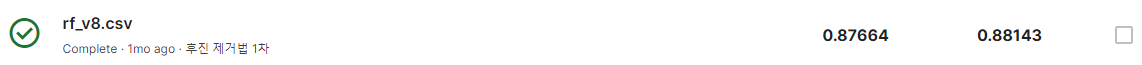

In [ ]:
# 변수의 개수가 많으므로, 변수를 제거하여 일반화 성능을 높이고자 한다

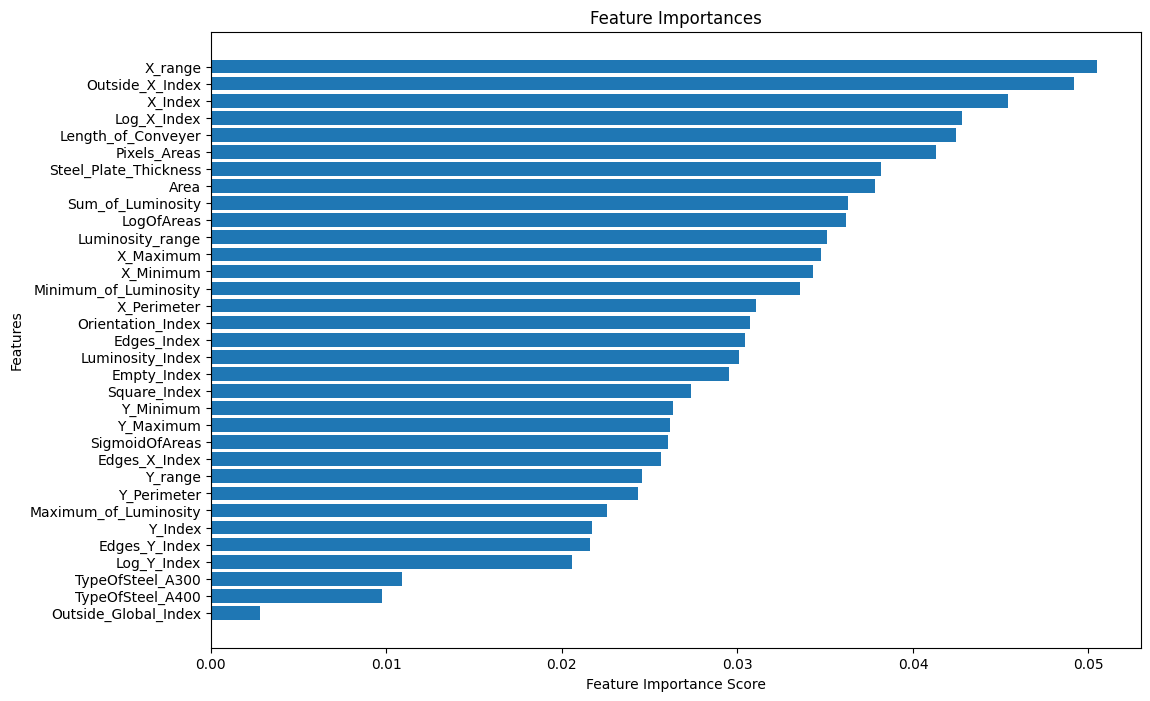

In [ ]:
feature_importances = pd.Series(rf_v7.feature_importances_, index=X_train_std.columns)
feature_importances = feature_importances.sort_values(ascending=False)

import matplotlib.pyplot as plt

# 중요도 그래프 그리기
plt.figure(figsize=(12, 8))
plt.barh(feature_importances.index, feature_importances)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # 역순으로 표시하여 가장 중요한 특징이 상단에 오도록 함
plt.show()

In [ ]:
# 가장 중요도가 낮은 Outside_Global_Index를 제거한다
X_train_std = X_train_std.drop('Outside_Global_Index', axis=1)
X_test_std = X_test_std.drop('Outside_Global_Index', axis=1)

In [ ]:
best_params = {'bootstrap': True, 'max_depth': 20, 'n_estimators': 700, 'verbose': 1}

In [ ]:
rf_v8 = RandomForestClassifier(**best_params)

In [ ]:
rf_v8.fit(X_train_std, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   30.8s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  1.2min


RandomForestClassifier(max_depth=20, n_estimators=700, verbose=1)

In [ ]:
rf_probs = rf_v8.predict_proba(X_test_std)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    7.4s


In [ ]:
# numpy 배열로 변환
rf_probs_np = np.array(rf_probs)

# 각 클래스에 속할 확률만을 추출
class_probs = rf_probs_np[:,:,1]

# DataFrame 생성
result_v8 = pd.DataFrame(class_probs).T
result_v8.columns = targets

# 결과 확인
result_v8

In [ ]:
# 결과를 csv로 저장한다
result_v8.insert(0, 'id', idx)
result_v8.to_csv('rf_v8.csv', index=False)

# 5. 소감

##**느낀점**
*   철판 데이터를 직접 다뤄보고 다른 사람들은 어떻게 했는지 찾아보면서 해본 결과, 성능이 점점 올라가는 것에 대해서 큰 재미를 느낄 수 있었다.
*   특히 피처 엔지니어링을 통해 만든 새로운 변수를 바탕으로 성능이 올라가는 것을 보며, 변수에 대해 다양한 접근 방법을 시도해보는 것이 중요하다는 것을 깨달을 수 있었다.
*   또한 데이터셋을 보강하면서 성능이 이전보다 확실하게 올라가는 지점이 있었을 때, 이를 바탕으로 데이터를 정제하는 것 역시 중요하지만 결과에 알맞는 데이터셋을 구하는 것이 중요하다는 것을 깨달았다.
*   이 경험을 바탕으로 EDA를 진행할 때 여러 각도로 볼 수 있을 것이라 생각할 수 있었다.



---


##**최종순위**
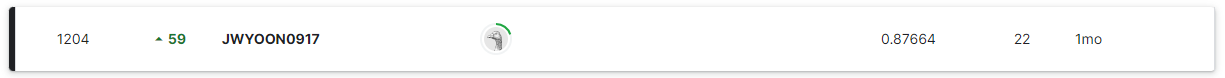